# NYC Taxi Fare Prediction
***Question: Can we predict a rider's taxi fare?***


In this notebook, we apply machine learning techniques to predict the fare amount for a taxi ride in New York City given the pickup/dropoff locations and pickup time.


**Table of Contents**

1. [Data Introduction](#1)<br>
2. [Exploratory Data Analysis](#2)<br>
    2.1. [Select a Random Subset](#2.1)<br>
    2.2. [Descriptive Statistics](#2.2)<br>
    2.3. [Geodata Visualization](#2.3)<br>
    2.4. [Pickup Time](#2.4)<br>
    2.5. [Effect of Weather Conditions](#2.5)<br>
3. [Regression](#3)<br>
    3.1. [Data Preparation and Feature Engineering](#3.1)<br>
    3.2. [LightGBM](#3.2)<br>
    3.3. [Neural Networks](#3.3)<br>
4. [Conclusions](#4)<br>

**Main packages used**: *sklearn*, *lightgbm*, *keras*, *pandas*, *numpy*, *matplotlib*.

For a qucik **summary of the results** from tested methods, please jump to [Conclusions](#4).

## 1. Data Introduction<a id="1"></a>

The data comes from a [Kaggle playground competition](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview) hosted by Google Cloud. 

The training dataset contains about 55M rows, with the following features:
- pickup_datetime
- pickup_longitude
- pickup_latitude
- dropoff_longitude
- dropoff_latitude
- passenger_count
The target is to predict the fare amount.

The test dataset contains 9914 rows without fare amount and is used to evaluate the performance.

**Baseline model**    
- A [basic estimate](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction) can be made based on just the distance between the two points, and this will result in an RMSE of 5-8 USD.

**Notes**
- Modeling uses a machine with configuration of **4 CPUs** and **16G RAM**. 
- Due to the memory limitation, only **about half of the training dataset is used**.
- **Evaluation Metric**: Root mean-squared error (RMSE) is used.

**Import library and load the data**

In [1]:
import numpy as np 
import pandas as pd
import scipy as scipy

import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import seaborn as sns

import os
import gc

In [2]:
# Reading Data
train_df =  pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv', nrows = 22000000)
print("In our training dataset, there are total {} rows.".format(train_df.shape[0]))
print("Datatype of each column:", train_df.dtypes)
train_df.head()

In our training dataset, there are total 22000000 rows.
Datatype of each column: key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


## 2. Exploratory Data Analysis<a id="2"></a>

### 2.1. Select a Random Subset<a id="2.1"></a>
Although only 22M lines were loaded, the dataset is still huge. Visualizing all of them might take too long and require too much memory. Let's randomly select ~ 1/10 of the data (2,000,000 rows).

In [3]:
df_visual = train_df.sample(n=2000000)
# reset index
df_visual.reset_index(drop=True, inplace=True)
df_visual.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-12-15 22:23:00.0000009,9.3,2009-12-15 22:23:00 UTC,-73.974753,40.753308,-73.979808,40.781100,3
1,2013-12-03 13:19:44.0000004,9.0,2013-12-03 13:19:44 UTC,-73.970701,40.755847,-73.957036,40.774601,2
2,2009-02-26 19:59:00.00000095,10.1,2009-02-26 19:59:00 UTC,-73.968068,40.800340,-73.967620,40.767113,1
3,2013-02-02 17:16:00.00000088,7.5,2013-02-02 17:16:00 UTC,-74.005020,40.740762,-73.988157,40.727962,1
4,2014-11-26 07:57:00.000000120,43.5,2014-11-26 07:57:00 UTC,-73.975730,40.750845,-73.996170,40.700182,1


### 2.2. Descriptive Statistics<a id="2.2"></a>

In [4]:
df_visual.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134520e+01,-7.251982e+01,3.991765e+01,-7.250608e+01,3.992052e+01,1.683449e+00
std,9.801801e+00,1.331647e+01,8.645470e+00,1.322003e+01,9.764600e+00,1.314936e+00
min,-6.200000e+01,-3.439245e+03,-3.114112e+03,-3.379079e+03,-3.092393e+03,0.000000e+00
25%,6.000000e+00,-7.399209e+01,4.073489e+01,-7.399139e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398182e+01,4.075262e+01,-7.398017e+01,4.075314e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076709e+01,-7.396371e+01,4.076810e+01,2.000000e+00
max,5.630400e+02,2.505494e+03,2.944649e+03,3.440820e+03,3.345917e+03,2.080000e+02


Plot their distributions using boxplot.

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


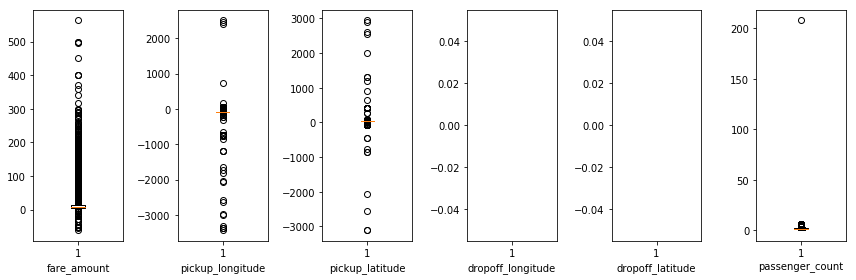

In [5]:
fig, axs = plt.subplots(1, 6, figsize=(12,4))
cols = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
for i, col in enumerate(cols):
    axs[i].boxplot(df_visual[col])
    axs[i].set_xlabel(col)
    # axs[i].set_ylabel('Fare ($USD)')
plt.tight_layout()
plt.show()

From the descriptive statistics and box plots, we make the following **observations**:
- Some of the pickup/dropoff locations have unreasonable coordinates, as shown by the min/max values. We should create a bounding box to remove those unrealistic ones or ones far away from NYC.
- In the dataset, passenger count can be 0, not useful.
- In the dataset, fare amount can be negative, which could be due to refund(?). Again, not useful.
- The average fare_amount is about 11.3 USD with a standard deviation of 9.8 USD.


One note on claiming some data "**not useful**": 
- Some are known to be incorrect, so those are truely no use. 
- Some of them may be in fact important, for example, if we know a refund happens, the fare should be negative. However, due to lack of information, we have to treat them as "not useful".

In [6]:
# select points with a bounding box
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

def clean_df(df, BB):
    idx = select_within_boundingbox(df, BB)
    df = df[idx]
    return df[(df.fare_amount > 0)  & (df.fare_amount <= 500) &
          # (df.passenger_count >= 0) & (df.passenger_count <= 8)  &
           ((df.pickup_longitude != 0) & (df.pickup_latitude != 0) & (df.dropoff_longitude != 0) & (df.dropoff_latitude != 0) )]

In [7]:
# drop null
df_visual = df_visual.dropna(how = 'any', axis = 'rows')
# later, this can be set as the box including all the test dataset locations
BB = (-74.1, -73.7, 40.6, 40.9)   
df_visual = clean_df(df_visual, BB)
print("After cleaning the data, there are {} rows left.".format(df_visual.shape[0]))

After cleaning the data, there are 1949843 rows left.


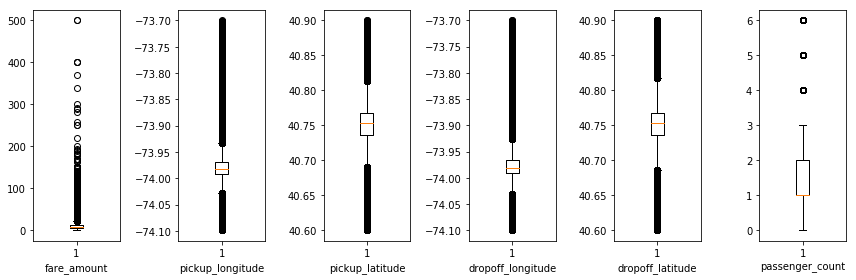

In [8]:
fig, axs = plt.subplots(1, 6, figsize=(12,4))
cols = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
for i, col in enumerate(cols):
    axs[i].boxplot(df_visual[col])
    axs[i].set_xlabel(col)
    # axs[i].set_ylabel('Fare ($USD)')
plt.tight_layout()
plt.show()

Now, the boxplot looks more or less showing the reasonable range, although there are still some outliers.

Next, let's plot the histogram of the fare amounts.

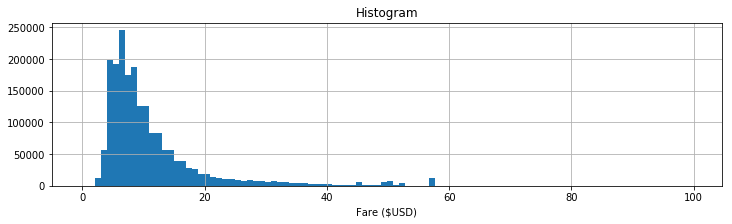

In [9]:
# plot histogram of fare
df_visual[df_visual.fare_amount<100].fare_amount.hist(bins=100, figsize=(12,3))
plt.xlabel('Fare ($USD)')
plt.title('Histogram')
plt.show()

We can see that the fare distribution is **right-skewed** (positive skewness, i.e., mean is greater than median), and roughly follows a log-normal distribution. In addition, there are some spikes between 40 and 60, which could indicate some **fixed fare trips**, such as to/from airport.

Distribution of passenger counts is plotted next.

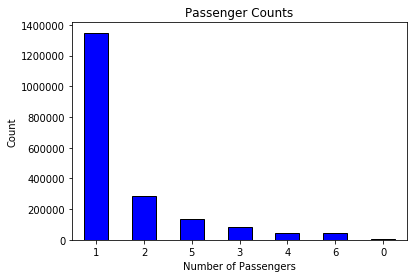

In [10]:
df_visual['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k', rot=0)
plt.title('Passenger Counts')
plt.xlabel('Number of Passengers')
plt.ylabel('Count')
plt.show()

Some trips have 0 passenger, which is odd. Also, due to that this is a small subset of the whole data, not all possibilities of the passenger counts are reflected in above plot.

### 2.3. Geodata Visualization<a id="2.3"></a>
Since we are dealing with location data, we can view them on a map. In fact, by using tiny dots and plot the coordinates as scatter plot, the city of New York can be clearly visulized.

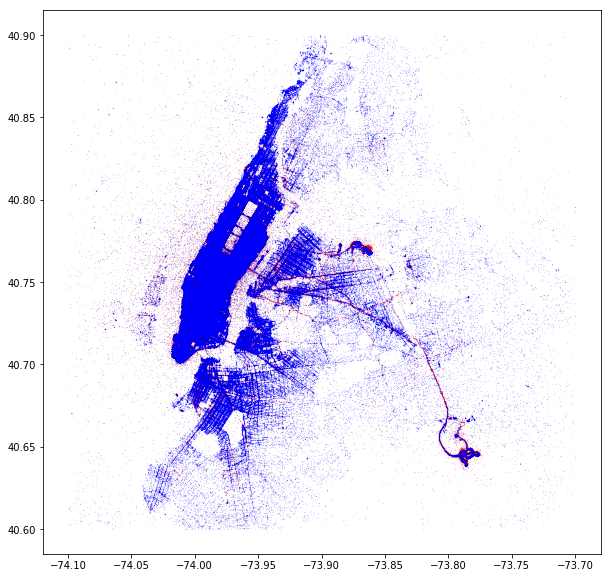

In [11]:
# plot the locations (pickup as red and dropoff as blue) of rows as scatter plot
def plot_hires(df, BB, figsize=(10, 10), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)
    plt.show()

plot_hires(df_visual, BB)

Aha, new york! Interestingly, we can even see the layout of the streets (for the Manhattan, need to zoom in to see the details.)

**Distance Calculation**

In this problem, we expect that the longer the distance traveled, the higher the fare is. Next we define a function to calculate the distance given the location coordinates.

In [12]:
# To Compute Haversine distance (great-circle distance between tow points on a sphere given their longitudes and latitudes)
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates. 
    unit: km
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))

Calculate the distance and plot the histogram of traveled distance.

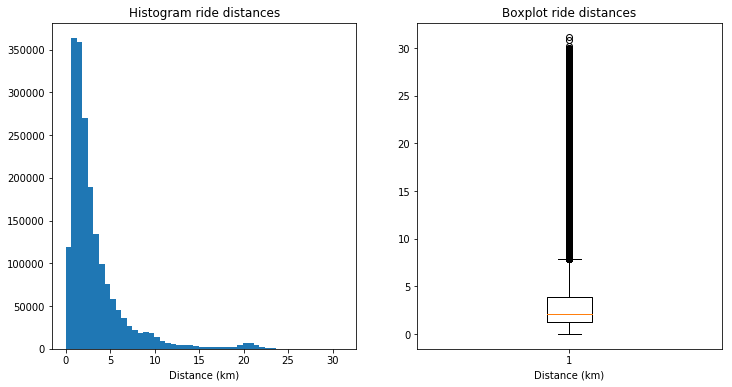

In [13]:
df_visual['distance'] = sphere_dist(df_visual['pickup_latitude'], df_visual['pickup_longitude'], 
                                   df_visual['dropoff_latitude'] , df_visual['dropoff_longitude']) 



fig, axs = plt.subplots(1, 2, figsize=(12,6))
idx = (df_visual.distance < 60)
axs[0].hist(df_visual[idx].distance, bins=50)
axs[0].set_xlabel('Distance (km)')
axs[0].set_title('Histogram ride distances')

axs[1].boxplot(df_visual[idx].distance)
axs[1].set_xlabel('Distance (km)')
axs[1].set_title('Boxplot ride distances')

plt.show()

Plot fare amount vs. distance traveled.

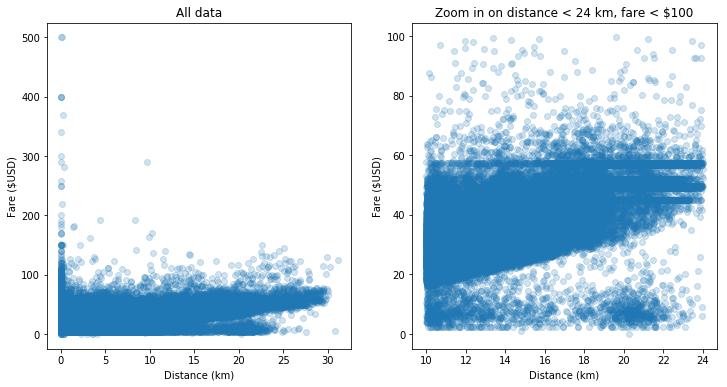

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
idx = (df_visual.distance < 120)
axs[0].scatter(df_visual[idx].distance, df_visual[idx].fare_amount, alpha=0.2)
axs[0].set_xlabel('Distance (km)')
axs[0].set_ylabel('Fare ($USD)')
axs[0].set_title('All data')

# zoom in on part of data
idx = (df_visual.distance < 24) & (df_visual.distance > 10) & (df_visual.fare_amount < 100)
axs[1].scatter(df_visual[idx].distance, df_visual[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('Distance (km)')
axs[1].set_ylabel('Fare ($USD)')
axs[1].set_title('Zoom in on distance < 24 km, fare < $100')

plt.show()

Some **observations** regarding the trip distances:
- There are trips with zero distance but non-zero fare. Could these be ***round trips***? Predicting this type of fares will be difficult because there is no such information in the dataset.
- There are some trips with > 20 km travel distance but very low fare. Perhaps these are discounted trips (even free ride)? 
- The horizontal lines in the right plot might indicate again the fixed fare trips to/from NYC airports (JFK, LGA, etc.).

### 2.4. Pickup Time<a id="2.4"></a>
For taxi fares, we also expect at different times of the day, the charge may vary. In order to show the time effect on taxi fare, we will also calculate the **fare per kilometer** (km) to cancel out the effect of trip distance.

In [15]:
# split the time information
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    dataset['time_stamp'] = dataset['year'].astype('str') + '-' + dataset['month'].astype('str') + '-' + dataset['day'].astype('str') + ':' + dataset['hour'].astype('str')
    
    return dataset

In [16]:
# select distance bigger than a cutoff. For distance = 0, fare per distance won't make sense.
cutoff_d = 1
idx = (df_visual.distance > cutoff_d)
df_visual = df_visual[idx]
print("For distance > {}, shape of the new dataframe = {}.".format(cutoff_d, df_visual.shape))

df_visual = add_datetime_info(df_visual)
df_visual['fare_per_km'] = df_visual.fare_amount / df_visual.distance

df_visual.head()

For distance > 1, shape of the new dataframe = (1626853, 9).


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour,day,month,weekday,year,time_stamp,fare_per_km
0,2009-12-15 22:23:00.0000009,9.3,2009-12-15 22:23:00,-73.974753,40.753308,-73.979808,40.781100,3,3.119514,22,15,12,1,2009,2009-12-15:22,2.981234
1,2013-12-03 13:19:44.0000004,9.0,2013-12-03 13:19:44,-73.970701,40.755847,-73.957036,40.774601,2,2.381830,13,3,12,1,2013,2013-12-3:13,3.778606
2,2009-02-26 19:59:00.00000095,10.1,2009-02-26 19:59:00,-73.968068,40.800340,-73.967620,40.767113,1,3.694866,19,26,2,3,2009,2009-2-26:19,2.733522
3,2013-02-02 17:16:00.00000088,7.5,2013-02-02 17:16:00,-74.005020,40.740762,-73.988157,40.727962,1,2.011100,17,2,2,5,2013,2013-2-2:17,3.729302
4,2014-11-26 07:57:00.000000120,43.5,2014-11-26 07:57:00,-73.975730,40.750845,-73.996170,40.700182,1,5.890907,7,26,11,2,2014,2014-11-26:7,7.384262


In the next plot, using the default aggregation function "*mean*", we plot the fare per km as the function of hours in a day for different years.

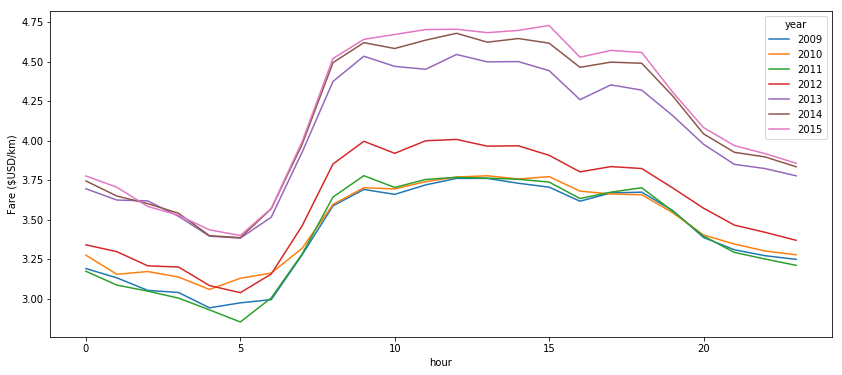

In [17]:
# display pivot table
df_visual.pivot_table('fare_per_km', index='hour', columns='year').plot(figsize=(14,6))
plt.ylabel('Fare ($USD/km)')
plt.show()

Obviously, for each year, the variation of the fare per km with hour is similar, with 5am being the lowest (very likely to be long distance travel, such as to airport) and 10am-3pm being the highest (trafic issue could significantly increase the fare per km due to delay).

In addition, we see that there is steady increase in the fare with year and a big jump from 2012 to 2013.

### 2.5. Effect of Weather Conditions<a id="2.5"></a>
Weather could also have some effect on the taxi fare in several ways. It may cause enlongated travel time for extra charge, may cause certain road closed so that detour has to be taken for extra charge, etc.

The dataset for the NYC weather 2009-2015 is from [Kaggle](https://www.kaggle.com/jiridobes/nyc-weather-20092015). The data include 'HOURLYVISIBILITY', 'HOURLYDRYBULBTEMPC', 'HOURLYWindSpeed', 'HOURLYPrecip', 'DAILYPrecip', 'DAILYSnowfall', 'DAILYSnowDepth'.

In [18]:
weather_df =  pd.read_csv('../input/nyc-weather/nyc_weather_data/1428442.csv',usecols=['DATE','HOURLYVISIBILITY','HOURLYDRYBULBTEMPC','HOURLYWindSpeed',
    'HOURLYPrecip','DAILYPrecip','DAILYSnowfall','DAILYSnowDepth'],dtype={'HOURLYVISIBILITY':str,'HOURLYDRYBULBTEMPC':str,
    'HOURLYPrecip':str,'DAILYPrecip':str,'DAILYSnowfall':str,'DAILYSnowDepth':str})
weather_df.head()

,DATE,HOURLYVISIBILITY,HOURLYDRYBULBTEMPC,HOURLYWindSpeed,HOURLYPrecip,DAILYPrecip,DAILYSnowfall,DAILYSnowDepth
0,2009-01-01 00:51,10.00,-7.8,18.0,0.00,NaN,NaN,NaN
1,2009-01-01 01:51,10.00,-7.8,18.0,0.00,NaN,NaN,NaN
2,2009-01-01 02:51,10.00,-7.8,18.0,0.00,NaN,NaN,NaN
3,2009-01-01 03:51,10.00,-8.3,8.0,0.00,NaN,NaN,NaN
4,2009-01-01 04:51,10.00,-8.3,11.0,0.00,NaN,NaN,NaN


In [19]:
# clean up the weather dataframe
weather_df['HOURLYVISIBILITY'] = weather_df['HOURLYVISIBILITY'].str.replace('V','') # see the dataset documentation. T = trace etc.
weather_df['HOURLYDRYBULBTEMPC'] = weather_df['HOURLYDRYBULBTEMPC'].str.replace('s','')
weather_df['HOURLYPrecip'] = weather_df['HOURLYPrecip'].str.replace('s','')
weather_df['HOURLYPrecip'] = weather_df['HOURLYPrecip'].str.replace('T','0')
weather_df['DAILYPrecip'] = weather_df['DAILYPrecip'].str.replace('T','0')
weather_df['DAILYSnowfall'] = weather_df['DAILYSnowfall'].str.replace('T','0')
weather_df['DAILYSnowDepth'] = weather_df['DAILYSnowDepth'].str.replace('T','0')

col_touse = ['HOURLYVISIBILITY','HOURLYDRYBULBTEMPC','HOURLYWindSpeed','HOURLYPrecip','DAILYPrecip','DAILYSnowfall','DAILYSnowDepth']
weather_df[col_touse]=weather_df[col_touse].astype(np.float)

weather_df['DATE']=pd.to_datetime(weather_df['DATE'])
weather_df=weather_df.set_index('DATE')
weather_df=weather_df.resample('1H').nearest()
weather_df=weather_df.fillna(method='ffill')
weather_df=weather_df.fillna(method='bfill')

weather_df=weather_df.reset_index()

Create a tiem_stamp column for merging purpose.

In [20]:
weather_df['time_stamp'] = weather_df['DATE'].dt.year.astype('str') + '-' + weather_df['DATE'].dt.month.astype('str') + '-' + weather_df['DATE'].dt.day.astype('str') + ':' + weather_df['DATE'].dt.hour.astype('str')
weather_df.head()

,DATE,HOURLYVISIBILITY,HOURLYDRYBULBTEMPC,HOURLYWindSpeed,HOURLYPrecip,DAILYPrecip,DAILYSnowfall,DAILYSnowDepth,time_stamp
0,2009-01-01 00:00:00,10.0,-7.8,18.0,0.0,0.04,0.0,0.0,2009-1-1:0
1,2009-01-01 01:00:00,10.0,-7.8,18.0,0.0,0.04,0.0,0.0,2009-1-1:1
2,2009-01-01 02:00:00,10.0,-7.8,18.0,0.0,0.04,0.0,0.0,2009-1-1:2
3,2009-01-01 03:00:00,10.0,-7.8,18.0,0.0,0.04,0.0,0.0,2009-1-1:3
4,2009-01-01 04:00:00,10.0,-8.3,8.0,0.0,0.04,0.0,0.0,2009-1-1:4


In [21]:
# merge with our original data set
df_visual = df_visual.merge(weather_df, how='left', on=['time_stamp'])
df_visual.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour,day,month,weekday,year,time_stamp,fare_per_km,DATE,HOURLYVISIBILITY,HOURLYDRYBULBTEMPC,HOURLYWindSpeed,HOURLYPrecip,DAILYPrecip,DAILYSnowfall,DAILYSnowDepth
0,2009-12-15 22:23:00.0000009,9.3,2009-12-15 22:23:00,-73.974753,40.753308,-73.979808,40.781100,3,3.119514,22,15,12,1,2009,2009-12-15:22,2.981234,2009-12-15 22:00:00,10.0,7.2,8.0,0.00,0.00,0.0,0.0
1,2013-12-03 13:19:44.0000004,9.0,2013-12-03 13:19:44,-73.970701,40.755847,-73.957036,40.774601,2,2.381830,13,3,12,1,2013,2013-12-3:13,3.778606,2013-12-03 13:00:00,7.0,10.6,5.0,0.00,0.00,0.0,0.0
2,2009-02-26 19:59:00.00000095,10.1,2009-02-26 19:59:00,-73.968068,40.800340,-73.967620,40.767113,1,3.694866,19,26,2,3,2009,2009-2-26:19,2.733522,2009-02-26 19:00:00,10.0,7.8,0.0,0.00,0.00,0.0,0.0
3,2013-02-02 17:16:00.00000088,7.5,2013-02-02 17:16:00,-74.005020,40.740762,-73.988157,40.727962,1,2.011100,17,2,2,5,2013,2013-2-2:17,3.729302,2013-02-02 17:00:00,10.0,-2.2,3.0,0.00,0.00,0.0,0.0
4,2014-11-26 07:57:00.000000120,43.5,2014-11-26 07:57:00,-73.975730,40.750845,-73.996170,40.700182,1,5.890907,7,26,11,2,2014,2014-11-26:7,7.384262,2014-11-26 07:00:00,8.0,6.1,8.0,0.01,0.01,0.0,0.0


In order to see how the fare amount is correlated with the weather data, we calculate the correlation matrix next.

In [22]:
col_pair = ['fare_amount', 'fare_per_km', 'passenger_count', 'distance', 'HOURLYVISIBILITY', 'HOURLYDRYBULBTEMPC', 'HOURLYWindSpeed', 
            'HOURLYPrecip', 'DAILYPrecip', 'DAILYSnowfall', 'DAILYSnowDepth']
df_visual[col_pair].corr()

,fare_amount,fare_per_km,passenger_count,distance,HOURLYVISIBILITY,HOURLYDRYBULBTEMPC,HOURLYWindSpeed,HOURLYPrecip,DAILYPrecip,DAILYSnowfall,DAILYSnowDepth
fare_amount,1.000000,-0.078629,0.017329,0.900612,0.001361,0.008351,-0.020888,-0.001801,-0.003740,0.003031,0.006468
fare_per_km,-0.078629,1.000000,0.008428,-0.392628,-0.021836,-0.000387,0.006232,0.014727,-0.001692,0.008153,0.024762
passenger_count,0.017329,0.008428,1.000000,0.011855,0.005197,0.003201,-0.002565,-0.000560,-0.000691,0.001998,-0.001090
distance,0.900612,-0.392628,0.011855,1.000000,0.008565,0.007770,-0.017515,-0.004808,-0.002293,-0.000855,-0.005060
HOURLYVISIBILITY,0.001361,-0.021836,0.005197,0.008565,1.000000,0.005779,0.029538,-0.372285,-0.108551,-0.022105,-0.028747
HOURLYDRYBULBTEMPC,0.008351,-0.000387,0.003201,0.007770,0.005779,1.000000,-0.260691,-0.006125,-0.008889,-0.179228,-0.340970
HOURLYWindSpeed,-0.020888,0.006232,-0.002565,-0.017515,0.029538,-0.260691,1.000000,0.047957,0.033062,0.019422,0.054190
HOURLYPrecip,-0.001801,0.014727,-0.000560,-0.004808,-0.372285,-0.006125,0.047957,1.000000,0.049675,-0.003224,-0.014485
DAILYPrecip,-0.003740,-0.001692,-0.000691,-0.002293,-0.108551,-0.008889,0.033062,0.049675,1.000000,0.119440,-0.009626
DAILYSnowfall,0.003031,0.008153,0.001998,-0.000855,-0.022105,-0.179228,0.019422,-0.003224,0.119440,1.000000,0.222327


Well, 'fare_amount' and 'fare_per_km' seem to have little correlation with all the weather data. Therefore, in our modeling, due to memory limitation, the weather data is not used.

In [23]:
del df_visual
gc.collect()

3448

## 3. Regression<a id="3"></a>
Before modeling, we note again that we only uses 22M data points.

Based on our EDA, we can now clean the whole dataset and in addition to [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula), we will also compute the [Bearing distance](https://en.wikipedia.org/wiki/Bearing_(navigation)) and several special distances, such as to/from the NYC airports (JFK, LGA, EWR) and Statue of Liberty.

### 3.1. Data Cleaning and feature engineering<a id="3.1"></a>

As this dataset is huge, directly removing datapoints with missing/unreasonable data nearly has no effect on the training.

In [24]:
# Drop rows with null values
train_df = train_df.dropna(how = 'any', axis = 'rows')

BB = (-74.3, -72.9, 40.5, 41.8)  # bounding box selected based on test set
train_df = clean_df(train_df, BB)
print("After cleaning the data, there are {} rows left in the training set.".format(train_df.shape[0]))

After cleaning the data, there are 21530440 rows left in the training set.


In [25]:
# To compute Bearing distance between pickup and dropoff locations    
def sphere_dist_bear(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute bearing distance
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a    

def radian_conv(degree):
    """
    Return radian.
    """
    return  np.radians(degree) 

def add_special_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    SOL: Statue of Liberty 
    NYC: Newyork Central
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445)                # Statue of Liberty
    nyc_coord = (40.7141667,-74.0063889) 
    
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    
    dataset['jfk_dist'] = pickup_jfk + dropoff_jfk
    dataset['ewr_dist'] = pickup_ewr + dropoff_ewr
    dataset['lga_dist'] = pickup_lga + dropoff_lga
    dataset['sol_dist'] = pickup_sol + dropoff_sol
    dataset['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return dataset

A helper function to reduce memory usage.

In [26]:
# reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [27]:
train_df = add_datetime_info(train_df)

# Weather data
# train_df = train_df.merge(weather_df, how='left', on=['time_stamp'])

train_df = add_special_dist(train_df)

train_df['distance'] = sphere_dist(train_df['pickup_latitude'], train_df['pickup_longitude'], 
                                   train_df['dropoff_latitude'] , train_df['dropoff_longitude']) 

train_df['bearing'] = sphere_dist_bear(train_df['pickup_latitude'], train_df['pickup_longitude'], 
                                   train_df['dropoff_latitude'] , train_df['dropoff_longitude'])                                    
train_df['pickup_latitude'] = radian_conv(train_df['pickup_latitude'])
train_df['pickup_longitude'] = radian_conv(train_df['pickup_longitude'])
train_df['dropoff_latitude'] = radian_conv(train_df['dropoff_latitude'])
train_df['dropoff_longitude'] = radian_conv(train_df['dropoff_longitude'])

train_df = reduce_mem_usage(train_df)

Mem. usage decreased to 1314.11 Mb (63.6% reduction)


In [28]:
train_df.drop(columns=['key', 'pickup_datetime', 'time_stamp'], inplace=True)

y = train_df['fare_amount']
train_df = train_df.drop(columns=['fare_amount'])

print(train_df.head())

   pickup_longitude  pickup_latitude    ...     distance   bearing
0         -1.289062         0.710938    ...     1.031250 -2.917969
1         -1.291992         0.710449    ...     8.453125 -0.375244
2         -1.291016         0.711426    ...     1.389648  2.599609
3         -1.291016         0.710938    ...     2.798828  0.133911
4         -1.291016         0.711426    ...     1.999023 -0.502930

[5 rows x 17 columns]


### 3.2. LightGBM<a id="3.2"></a>
First split the training dataset into train/validation. Due to the total samples are more than 20M, we only use 5% of them as validation dataset.

In [29]:
# we have > 20M dataset, validation set is chosen to be 5% of the data
x_train,x_test,y_train,y_test = train_test_split(train_df, y, random_state=777, test_size=0.05)

del train_df
del y
gc.collect()

274

In [30]:
model = lgbm.LGBMRegressor(num_leaves=31, learning_rate=0.05,subsample=0.8,bagging_fraction=1.0,max_bin=5000,bagging_freq=20,
                           colsample_bytree=0.6,min_split_gain=0.5,min_child_weight=1,num_rounds=50000,metric='rmse',scale_pos_weight=1,
                           zero_as_missing=True,early_stopping_round=500, min_child_samples=10,n_jobs=-1,seed=0)

In [31]:
model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=500)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 3.64176
[1000]	valid_0's rmse: 3.58831
[1500]	valid_0's rmse: 3.56531
[2000]	valid_0's rmse: 3.55137
[2500]	valid_0's rmse: 3.54098
[3000]	valid_0's rmse: 3.53069
[3500]	valid_0's rmse: 3.52337
[4000]	valid_0's rmse: 3.51817
[4500]	valid_0's rmse: 3.5136
[5000]	valid_0's rmse: 3.51041
[5500]	valid_0's rmse: 3.50773
[6000]	valid_0's rmse: 3.50463
[6500]	valid_0's rmse: 3.50237
[7000]	valid_0's rmse: 3.50062
[7500]	valid_0's rmse: 3.49767
[8000]	valid_0's rmse: 3.49624
[8500]	valid_0's rmse: 3.49522
[9000]	valid_0's rmse: 3.49324
[9500]	valid_0's rmse: 3.49186
[10000]	valid_0's rmse: 3.49015
[10500]	valid_0's rmse: 3.48879
[11000]	valid_0's rmse: 3.48805
[11500]	valid_0's rmse: 3.48754
[12000]	valid_0's rmse: 3.48648
[12500]	valid_0's rmse: 3.48569
[13000]	valid_0's rmse: 3.48468
[13500]	valid_0's rmse: 3.48398
[14000]	valid_0's rmse: 3.48282
[14500]	valid_0's rmse: 3.48155
[15000]	valid_0's rmse: 3.4812

LGBMRegressor(bagging_fraction=1.0, bagging_freq=20, boosting_type='gbdt',
              class_weight=None, colsample_bytree=0.6, early_stopping_round=500,
              importance_type='split', learning_rate=0.05, max_bin=5000,
              max_depth=-1, metric='rmse', min_child_samples=10,
              min_child_weight=1, min_split_gain=0.5, n_estimators=100,
              n_jobs=-1, num_leaves=31, num_rounds=50000, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              scale_pos_weight=1, seed=0, silent=True, subsample=0.8,
              subsample_for_bin=200000, subsample_freq=0, zero_as_missing=True)

**Plot the feature importance**

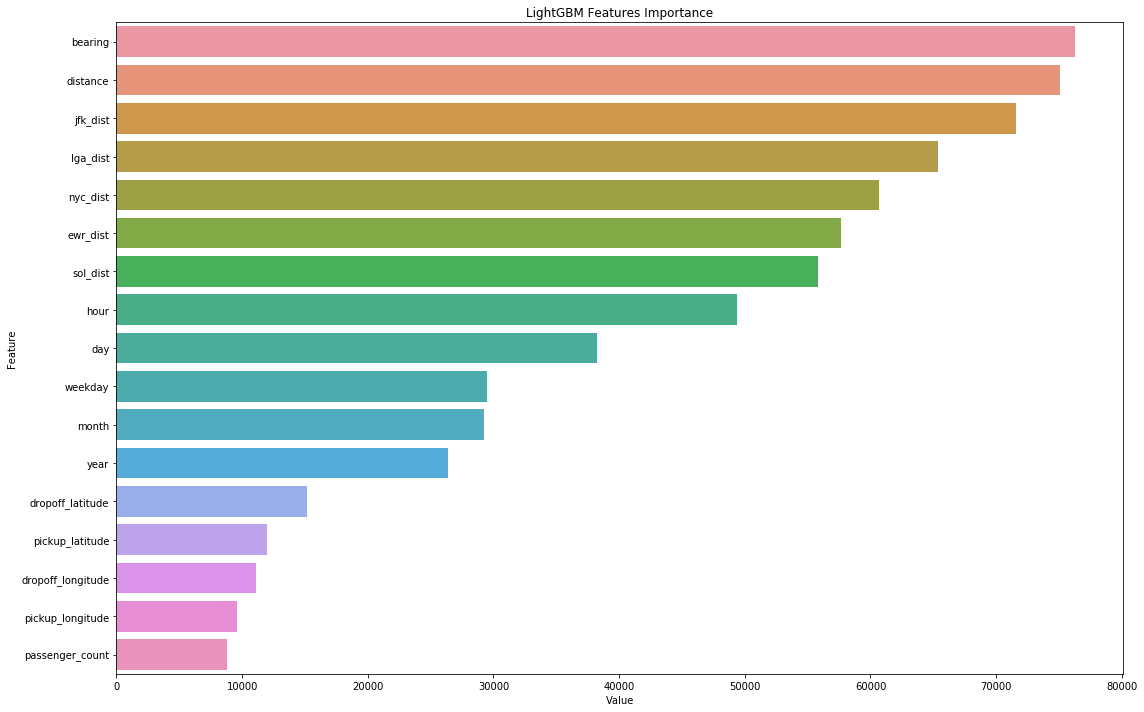

In [32]:
# plot feature importance
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(16, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.show()

The training carried out for 23500 rounds and triggered early stopping. We can see that the RMSE is about 3.47 in the validation set.

Based on the plotting of the **feature importances**, the two distances are the most important features in the prediction, followed by the "special" distances (to/from airports and landmarks). Pickup time plays less importance roles, but still contibute. 

In [33]:
del x_train
del y_train
del x_test
del y_test
gc.collect()

4709

#### Predict for the test set

In [34]:
test_df =  pd.read_csv('../input/new-york-city-taxi-fare-prediction/test.csv')
print(test_df.head())
test_df = add_datetime_info(test_df)
# weather
# test_df = test_df.merge(weather_df, how='left', on=['time_stamp'])

test_df = add_special_dist(test_df)

test_df['distance'] = sphere_dist(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                   test_df['dropoff_latitude'] , test_df['dropoff_longitude'])

test_df['bearing'] = sphere_dist_bear(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                    test_df['dropoff_latitude'] , test_df['dropoff_longitude'])  
test_df['pickup_latitude'] = radian_conv(test_df['pickup_latitude'])
test_df['pickup_longitude'] = radian_conv(test_df['pickup_longitude'])
test_df['dropoff_latitude'] = radian_conv(test_df['dropoff_latitude'])
test_df['dropoff_longitude'] = radian_conv(test_df['dropoff_longitude'])

test_key = test_df['key']
test_df = test_df.drop(columns=['key', 'pickup_datetime', 'time_stamp'])

                           key       ...       passenger_count
0  2015-01-27 13:08:24.0000002       ...                     1
1  2015-01-27 13:08:24.0000003       ...                     1
2  2011-10-08 11:53:44.0000002       ...                     1
3  2012-12-01 21:12:12.0000002       ...                     1
4  2012-12-01 21:12:12.0000003       ...                     1

[5 rows x 7 columns]


In [35]:
#Predict from test set
prediction = model.predict(test_df, num_iteration = model.best_iteration_)      
res = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction
})

res.to_csv('taxi_fare_prediction.csv',index=False)

After submitting this results, the RMSE score returned by Kaggle is about 2.88 USD for the unseen test dataset, which is better than our validation RMSE and shows big improvement compared with the baseline model (5-8 USD).

### 3.3. Neural Networks<a id="3.3"></a>
From our EDA and LightGBM training, we can tell one big problem of this question is lack of information. Features we created are not enough to describe all scenarios. Nonetheless, we will try a different method, deep neural network (NN), to see how it performs.

In our NN model, we will use the same training dataset as above, i.e. 22M lines and same features. 

**Network architecture**
- Stacking of all full connected (FC) layers.
- Two models are tried, one with ~ 86k parameters and the other with ~ 147k parameters.

In [1]:
import numpy as np 
import pandas as pd
import scipy as scipy
import time
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from keras import layers as L
from keras import backend as K
from keras.models import load_model

import os
import gc

Using TensorFlow backend.


In [2]:
# in fact, we only have 4 CPUs
conf = K.tf.ConfigProto(device_count={'CPU': 8},
                        intra_op_parallelism_threads=8,
                        inter_op_parallelism_threads=8)
K.set_session(K.tf.Session(config=conf))

#### 3.3.1. Smaller NN

In [17]:
# Define a NN model

def my_model():
    model = Sequential()
    model.add(L.Dense(64, kernel_initializer='normal', activation='relu', input_dim=17))
    model.add(L.Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(L.Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(L.Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(L.Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(L.Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(L.Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model = my_model()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1152      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total para

In [18]:
weight_path="early_weights.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=10)
callbacks = [checkpoint, early_stopping]

In [19]:
print('running NN...')
start = time.time()
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=100, batch_size=1024, callbacks=callbacks)
print("time used by NN = {}".format(time.time() - start))

running NN...
Train on 20453918 samples, validate on 1076522 samples
Epoch 1/100
20453918/20453918 [==============================] - 156s 8us/step - loss: 21.8074 - val_loss: 20.1672

Epoch 00001: val_loss improved from inf to 20.16719, saving model to early_weights.hdf5
Epoch 2/100
20453918/20453918 [==============================] - 158s 8us/step - loss: 19.4808 - val_loss: 18.9286

Epoch 00002: val_loss improved from 20.16719 to 18.92859, saving model to early_weights.hdf5
Epoch 3/100
20453918/20453918 [==============================] - 154s 8us/step - loss: 19.0558 - val_loss: 18.9834

Epoch 00003: val_loss did not improve from 18.92859
Epoch 4/100
20453918/20453918 [==============================] - 156s 8us/step - loss: 18.5111 - val_loss: 19.3913

Epoch 00004: val_loss did not improve from 18.92859
Epoch 5/100
20453918/20453918 [==============================] - 156s 8us/step - loss: 18.0111 - val_loss: 18.3019

Epoch 00005: val_loss improved from 18.92859 to 18.30194, saving m

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20453918/20453918 [==============================] - 157s 8us/step - loss: 16.1209 - val_loss: 16.5018

Epoch 00025: val_loss did not improve from 16.01786
Epoch 26/100
20453918/20453918 [==============================] - 157s 8us/step - loss: 16.1020 - val_loss: 16.0355

Epoch 00026: val_loss did not improve from 16.01786
Epoch 27/100
20453918/20453918 [==============================] - 157s 8us/step - loss: 16.0686 - val_loss: 16.3044

Epoch 00027: val_loss did not improve from 16.01786
Epoch 28/100
20453918/20453918 [==============================] - 157s 8us/step - loss: 16.0381 - val_loss: 16.4651

Epoch 00028: val_loss did not improve from 16.01786
Epoch 29/100
20453918/20453918 [==============================] - 158s 8us/step - loss: 16.0320 - val_loss: 16.1332

Epoch 00029: val_loss did not improve from 16.01786
Epoch 30/100
20453918/20453918 [==============================] - 157s 8us/step - loss: 16.0191 - val_loss: 16.0342

Epoch 00030: val_loss did not improve from 16.01786

In [20]:
# save the model for continuous training.
model.save("model.P86k.h5")
print("model saved to disk.")

model saved to disk.


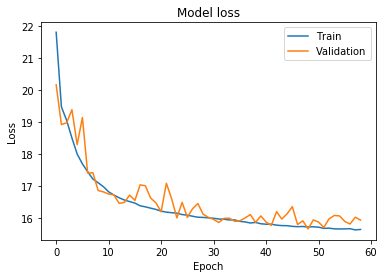

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

The training trigered the early stopping and ended at epoch 59. The best MSE = 15.67, i.e. RMSE ~ 3.95 USD. Next we load the model again and restart the training for another 20 epochs.

In [18]:
# load model saved from last run
saved_model = './model.P86k.h5'
model = load_model(saved_model)

In [22]:
print('continue running NN...')
start = time.time()
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=20, batch_size=1024, callbacks=callbacks)
print("time used by NN = {}".format(time.time() - start))

continue running NN...
Train on 20453918 samples, validate on 1076522 samples
Epoch 1/20
20453918/20453918 [==============================] - 162s 8us/step - loss: 15.6430 - val_loss: 15.9855

Epoch 00001: val_loss did not improve from 15.67348
Epoch 2/20
20453918/20453918 [==============================] - 166s 8us/step - loss: 15.6397 - val_loss: 15.7814

Epoch 00002: val_loss did not improve from 15.67348
Epoch 3/20
20453918/20453918 [==============================] - 165s 8us/step - loss: 15.6421 - val_loss: 15.5566

Epoch 00003: val_loss improved from 15.67348 to 15.55656, saving model to early_weights.hdf5
Epoch 4/20
20453918/20453918 [==============================] - 167s 8us/step - loss: 15.6370 - val_loss: 15.9571

Epoch 00004: val_loss did not improve from 15.55656
Epoch 5/20
20453918/20453918 [==============================] - 171s 8us/step - loss: 15.6288 - val_loss: 15.7212

Epoch 00005: val_loss did not improve from 15.55656
Epoch 6/20
20453918/20453918 [================

Not much improve from the re-training and it stopped after 13 epochs (early stopping).

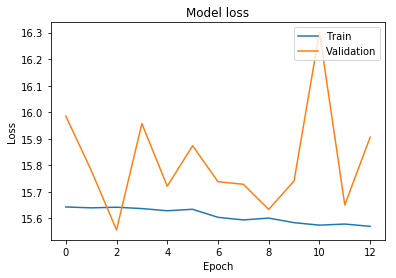

In [23]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [30]:
#Predict from test set
prediction = model.predict(test_df)      
res = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction.flatten()
})

res.to_csv('taxi_fare_prediction.csv',index=False)

After submission, the RMSE = 3.42 USD from Kaggle website. **This is worse than our LightGBM model.**

#### 3.3.2. A larger NN

In [24]:
def larger_model():
    model = Sequential()
    model.add(L.Dense(64, kernel_initializer='normal', activation='relu', input_dim=17))
    model.add(L.Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(L.Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(L.Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(L.Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(L.Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(L.Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(L.Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(L.Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model2 = larger_model()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                1152      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
__________

In [25]:
print('running NN...')
start = time.time()
history = model2.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=50, batch_size=1024, callbacks=callbacks)
print("time used by NN = {}".format(time.time() - start))

running NN...
Train on 20453918 samples, validate on 1076522 samples
Epoch 1/50
20453918/20453918 [==============================] - 228s 11us/step - loss: 21.6761 - val_loss: 19.3119

Epoch 00001: val_loss did not improve from 15.55656
Epoch 2/50
20453918/20453918 [==============================] - 227s 11us/step - loss: 19.4869 - val_loss: 19.1734

Epoch 00002: val_loss did not improve from 15.55656
Epoch 3/50
20453918/20453918 [==============================] - 227s 11us/step - loss: 18.6256 - val_loss: 18.0183

Epoch 00003: val_loss did not improve from 15.55656
Epoch 4/50
20453918/20453918 [==============================] - 227s 11us/step - loss: 18.1334 - val_loss: 17.5425

Epoch 00004: val_loss did not improve from 15.55656
Epoch 5/50
20453918/20453918 [==============================] - 234s 11us/step - loss: 17.7190 - val_loss: 17.3309

Epoch 00005: val_loss did not improve from 15.55656
Epoch 6/50
20453918/20453918 [==============================] - 242s 12us/step - loss: 17.2

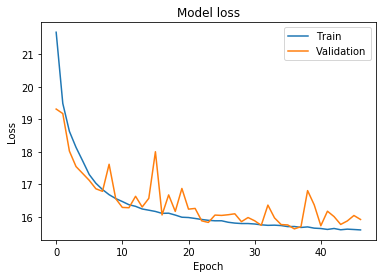

In [26]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [31]:
#Predict from test set
prediction = model2.predict(test_df)      
res = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction.flatten()
})

res.to_csv('taxi_fare_prediction2.csv',index=False)

After submission, the RMSE = 3.50 USD, similar to the smaller NN model, worse than the LightGBM model.

## 4. Conclusions<a id="4"></a>

In this work, we used the **pickup/dropoff locations** and **pickup time** to predict the taxi fare in NYC. First, a summary of the model performance is listed in the following table:

| Method        | Training rounds (epochs)    | RMSE (USD)    | 
| ------------- |:-------------:|:-------------:| 
| LightGBM      | 23500          | 2.88          | 
| NN (86,000 parameters)   | 72          | 3.42         | 
| NN (147,000 parameters)  | 47          | 3.50         | 


The root mean squared error (RMSE) is around 3 USD, which is better than the baseline model (MSE = 5-8 USD), but not ideal.

From this study we learned,
- The new features created based on the pickup/dropoff locations show great importance in our regression model, the **Haversine distance** and **Bearing distance** in particular. **Distance to airports and landmarks** are also shown to be useful.


- In my opinion, the biggest obstacle in this study to obtain very accurate results is <span style="color:red">**the lack of information**</span>, which can be important in the prediction of fare amount: 
    - how much time the trip took (only pickup time was provided)
    - if the trip is canceled or refunded.
    - if the trip is a round trip; when it is, the pickup location is the same as the dropoff location, then what is the distance traveled?
    
    
- In our study, neural network models do not perform better than the gradient boosting tree methods. The improvement could come from designing better architectures. However without necessary input features, I doubt the NN can learn above information from any architecture.